# Create water balance from database<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 22, 2019_
<hr>

This notebook describes how a water balance can be set up using output from the Waternet waterbalansen database.

## Contents
- [Read database output](#1)
    - [Modelstructure](#1.1)
    - [Timeseries](#1.2)
    - [Model parameters](#1.3)
- [Create the model](#2)
- [Simulate the water balance](#3)
- [Visualize the results](#4)
- [Running water balances from the database the easy way](#5)

Import the requisite modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import waterbalans as wb

Pick an EAG and a start and end time for the simulation

In [2]:
# Basisgegevens
# -------------
# Naam en ID van gebied
eag_id = "3"
eag_name = "2140-EAG-3"

# Begin en eindtijd simulatie
tmin = "1996"
tmax = "2015"

## [Read database output](#top)<a id="1"></a>

The Waternet waterbalansen database contains:
- modelstructure: information about which buckets are present in the model for a particular EAG or GAF
- parameters: the parameters for the buckets and all of the other processes in an EAG/GAF
- timeseries:
    - the Constants, ValuesSeries and FEWS Ids of the relevant timeseries
    - the additional timeseries that cannot be entered through the previous method

Queries have been defined that export the data from the database into sets of CSV files containing all of the information needed to create a water balance. By default the script that performs these queries, exports the following CSV files. The default filename is also shown:



| CSV file                                            | Filename                                 |
| :---                                                | :---                                     |
| **modelstructure**                                  | `opp_<EAGID>_<EAGNAME>.csv`              |
| **timeseries (Constant, ValueSeries, FEWS, KNMI)**  | `reeks_<EAGID>_<EAGNAME>.csv`            |
| **other timeseries**                                | `series_<EAGID>_<EAGNAME>.csv`           |
| **model parameters**                                | `param_<EAGID>_<EAGNAME>.csv`            |
| **parameters for chloride simulation**              | `stoffen_chloride_<EAGID>_<EAGNAME>.csv` |
| **parameters for phosphorous simulation**           | `stoffen_fosfor_<EAGID>_<EAGNAME>.csv`   |


#### [Modelstructure](#top)<a id="1.1"></a>

The modelstructure data is loaded and shown

In [3]:
# bestand met deelgebieden en oppervlaktes:
deelgebieden = pd.read_csv(r"../../data/input_csv/opp_60_2140-EAG-3.csv", delimiter=";")
deelgebieden

,EAGID,EAGCode,BakjeID,BakjeOmschrijving,BakjePyCode,OppWaarde
0,60,2140-EAG-3,60000122,Verhard,Verhard,84288.0
1,60,2140-EAG-3,60000123,OnverhardOngedraineerd,Onverhard,85972.0
2,60,2140-EAG-3,60000000,Water,Water,141669.0


#### [Timeseries](#top)<a id="1.2"></a>

The timeseries that can be entered as Constants, ValueSeries of have to be loaded from FEWS are loaded from the `reeks_<EAGID>_<EAG Name>.csv` file. Only the first 10 rows are shown:

In [4]:
# bestand met tijdreeksen, b.v. neerslag/verdamping:
tijdreeksen = pd.read_csv(
    r"../../data/input_csv/reeks_60_2140-EAG-3.csv", delimiter=";"
)
# show first 10 rows
tijdreeksen.head(10)

,EAGID,EAGCode,BakjeID,Laagvolgorde,ClusterType,ParamType,Waarde,WaardeAlfa,StartDag,Eenheid
0,60,2140-EAG-3,60000122,2,Qkwel,Constant,-0.83,NaN,NaN,mm/dag
1,60,2140-EAG-3,60000123,1,Qkwel,Constant,-0.83,NaN,NaN,mm/dag
2,60,2140-EAG-3,60000000,1,Qkwel,Constant,0.00,NaN,NaN,mm/dag
3,60,2140-EAG-3,60000000,1,Qwegz,Constant,0.83,NaN,NaN,mm/dag
4,60,2140-EAG-3,60000000,1,hTargetMax,ValueSeries,-1.70,NaN,01-05,mNAP
5,60,2140-EAG-3,60000000,1,hTargetMax,ValueSeries,-1.70,NaN,01-10,mNAP
6,60,2140-EAG-3,60000000,1,hTargetMax,ValueSeries,-1.70,NaN,15-03,mNAP
7,60,2140-EAG-3,60000000,1,hTargetMax,ValueSeries,-1.70,NaN,15-08,mNAP
8,60,2140-EAG-3,60000000,1,hTargetMin,ValueSeries,-1.75,NaN,01-05,mNAP
9,60,2140-EAG-3,60000000,1,hTargetMin,ValueSeries,-1.75,NaN,01-10,mNAP


The timeseries that cannot be added through the table above are loaded from `series_<EAGID>_<EAG Name>.csv`. These are the full series, so only the first 10 rows are shown:

In [5]:
# bestand met overige tijdreeksen
series = pd.read_csv(
    r"../../data/input_csv/series_60_2140-EAG-3.csv",
    delimiter=";",
    index_col=[0],
    parse_dates=True,
)
# show first 10 rows
series.head(10)

,1|Immissie,Inlaat1|Watsonweg (EAG-6),Neerslag1|Neerslag,Peil1|Peil,q_cso1|Gemengd Gerioleerd Stelsel,Uitlaat2|provinciale weg,Uitlaat3|boterdijk,Verdamping1|Verdamping
datum,,,,,,,,
1996-01-01,150.0,22153.601586,0.1,NaN,0.0,NaN,NaN,0.2
1996-01-02,NaN,24998.635628,0.0,NaN,0.0,NaN,NaN,0.3
1996-01-03,NaN,14860.399178,0.0,NaN,0.0,NaN,NaN,0.3
1996-01-04,NaN,9262.683520,0.0,NaN,0.0,NaN,NaN,0.3
1996-01-05,NaN,6031.618336,0.0,-1.665,0.0,NaN,NaN,0.2
1996-01-06,NaN,4753.281108,1.7,-1.665,0.0,NaN,NaN,0.1
1996-01-07,NaN,5082.952640,1.9,-1.661,0.0,NaN,NaN,0.3
1996-01-08,NaN,3172.548282,0.0,-1.656,0.0,NaN,NaN,0.1
1996-01-09,NaN,2728.586874,0.9,-1.655,0.0,NaN,NaN,0.1


#### [Model parameters](#top)<a id="1.3"></a>

The model parameters are loaded and shown

In [6]:
# bestand met parameters per deelgebied
parameters = pd.read_csv(r"../../data/input_csv/param_60_2140-EAG-3.csv", delimiter=";")
parameters

,EAGID,EAGCode,BakjeID,Laagvolgorde,ParamCode,Waarde,Eenheid
0,60,2140-EAG-3,60000122,1,hMax,0.002,m
1,60,2140-EAG-3,60000122,2,RFacOut,0.010,NaN
2,60,2140-EAG-3,60000122,2,RFacIn,0.010,NaN
3,60,2140-EAG-3,60000122,2,por,0.200,NaN
4,60,2140-EAG-3,60000122,2,hMax,1.000,m
5,60,2140-EAG-3,60000122,2,hInit,0.500,m
6,60,2140-EAG-3,60000123,1,RFacOut,0.500,NaN
7,60,2140-EAG-3,60000123,1,RFacIn,0.020,NaN
8,60,2140-EAG-3,60000123,1,por,0.200,NaN
9,60,2140-EAG-3,60000123,1,hMax,1.000,m


## [Create the model](#top)<a id="2"></a>

Create the model using `wb.create_eag()`

In [7]:
# Maak bakjes model
e = wb.create_eag(eag_id, eag_name, deelgebieden)

2024-11-04 17:02:49,479 | create_eag - INFO : Creating EAG object for '2140-EAG-3'


Add the timeseries. First the ones defined by their labels (FEWS, ValueSeries, Constants):

In [8]:
# Voeg tijdreeksen toe
e.add_series_from_database(tijdreeksen, tmin=tmin, tmax=tmax)

2024-11-04 17:02:49,525 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2024-11-04 17:02:49,527 | get_series - INFO : Adding ValueSeries timeseries 'Uitlaat1' for Bucket '-9999'.
2024-11-04 17:02:49,535 | get_series - INFO : Adding ValueSeries timeseries 'hTargetMin' for Bucket '60000000'.
2024-11-04 17:02:49,544 | get_series - INFO : Adding ValueSeries timeseries 'hTargetMax' for Bucket '60000000'.
2024-11-04 17:02:49,551 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 2' for Bucket '-9999'.
2024-11-04 17:02:49,552 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 1' for Bucket '-9999'.
2024-11-04 17:02:49,553 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 2' for Bucket '-9999'.
2024-11-04 17:02:49,555 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 1' for Bucket '-9999'.
2024-11-04 17:02:49,556 | get_series - INFO : Adding Local timeseries 'Gemaal3Debiet Pomp 2' for B

2024-11-04 17:02:49,561 | get_series - INFO : Adding Local timeseries 'Uitlaat1' for Bucket '-9999'.
2024-11-04 17:02:49,562 | get_series - INFO : Adding Local timeseries 'Inlaat4' for Bucket '-9999'.
2024-11-04 17:02:49,563 | get_series - INFO : Adding Local timeseries 'Inlaat3' for Bucket '-9999'.
2024-11-04 17:02:49,564 | get_series - INFO : Adding Local timeseries 'Inlaat2' for Bucket '-9999'.
2024-11-04 17:02:49,565 | get_series - INFO : Adding Local timeseries 'Inlaat1' for Bucket '-9999'.
2024-11-04 17:02:49,569 | get_series - WARNING : Pi service cannot be started. Module will not import series from FEWS!
2024-11-04 17:02:49,570 | get_series - WARNING : Adding series 'Neerslag' of kind 'FEWS' not supported.
2024-11-04 17:02:49,572 | get_series - WARNING : Pi service cannot be started. Module will not import series from FEWS!
2024-11-04 17:02:49,574 | get_series - WARNING : Adding series 'Peil' of kind 'FEWS' not supported.
2024-11-04 17:02:49,577 | get_series - WARNING : Pi ser

Next add the remaining timeseries that have to be passed explicitly:

In [9]:
# Voeg overige tijdreeksen toe
wb.add_timeseries_to_obj(e, series)

2024-11-04 17:02:49,607 | add_timeseries - INFO : Adding timeseries 'Inlaat1' to EAG manually
2024-11-04 17:02:49,612 | add_timeseries - INFO : Adding timeseries 'Uitlaat2' to EAG manually


2024-11-04 17:02:49,613 | add_timeseries - INFO : Filled 5631 NaN-values with '0.0' in series Uitlaat2.
2024-11-04 17:02:49,619 | add_timeseries - INFO : Adding timeseries 'Uitlaat3' to EAG manually
2024-11-04 17:02:49,620 | add_timeseries - INFO : Filled 469 NaN-values with '0.0' in series Uitlaat3.
2024-11-04 17:02:49,623 | add_timeseries - INFO : Adding timeseries 'Peil' to EAG manually
2024-11-04 17:02:49,624 | add_timeseries - INFO : Filled 517 NaN-values with 'ffill' in series Peil.
2024-11-04 17:02:49,628 | add_timeseries - INFO : Adding timeseries 'q_cso' to EAG manually
2024-11-04 17:02:49,633 | add_timeseries - INFO : Adding timeseries 'Neerslag' to EAG manually
2024-11-04 17:02:49,634 | add_timeseries - INFO : Filled 1 NaN-values with '0.0' in series Neerslag.
2024-11-04 17:02:49,638 | add_timeseries - INFO : Adding timeseries 'Verdamping' to EAG manually
2024-11-04 17:02:49,639 | add_timeseries - INFO : Filled 1 NaN-values with '0.0' in series Verdamping.


## [Simulate the water balance](#top)<a id="3"></a>

Next simulate the water balance

In [10]:
# Simuleer waterbalans met parameters
e.simulate(parameters, tmin=tmin, tmax=tmax)

2024-11-04 17:02:49,660 | simulate - INFO : Simulating: 2140-EAG-3...
2024-11-04 17:02:49,662 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 60000122
2024-11-04 17:02:50,767 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 60000123
2024-11-04 17:02:51,126 | simulate - INFO : Simulating the waterbalance for bucket: Water 60000000
2024-11-04 17:02:51,134 | simulate - INFO : Using hTarget-timeseries, not hTarget-parameters!
/home/david/github/waterbalans/waterbalans/utils.py:53: RuntimeWarning: divide by zero encountered in divide
  penman = 1.0 / np.array(
2024-11-04 17:02:51,426 | simulate - INFO : Simulation succesfully completed in 1.8s.


## [Visualize the results](#top)<a id="4"></a>

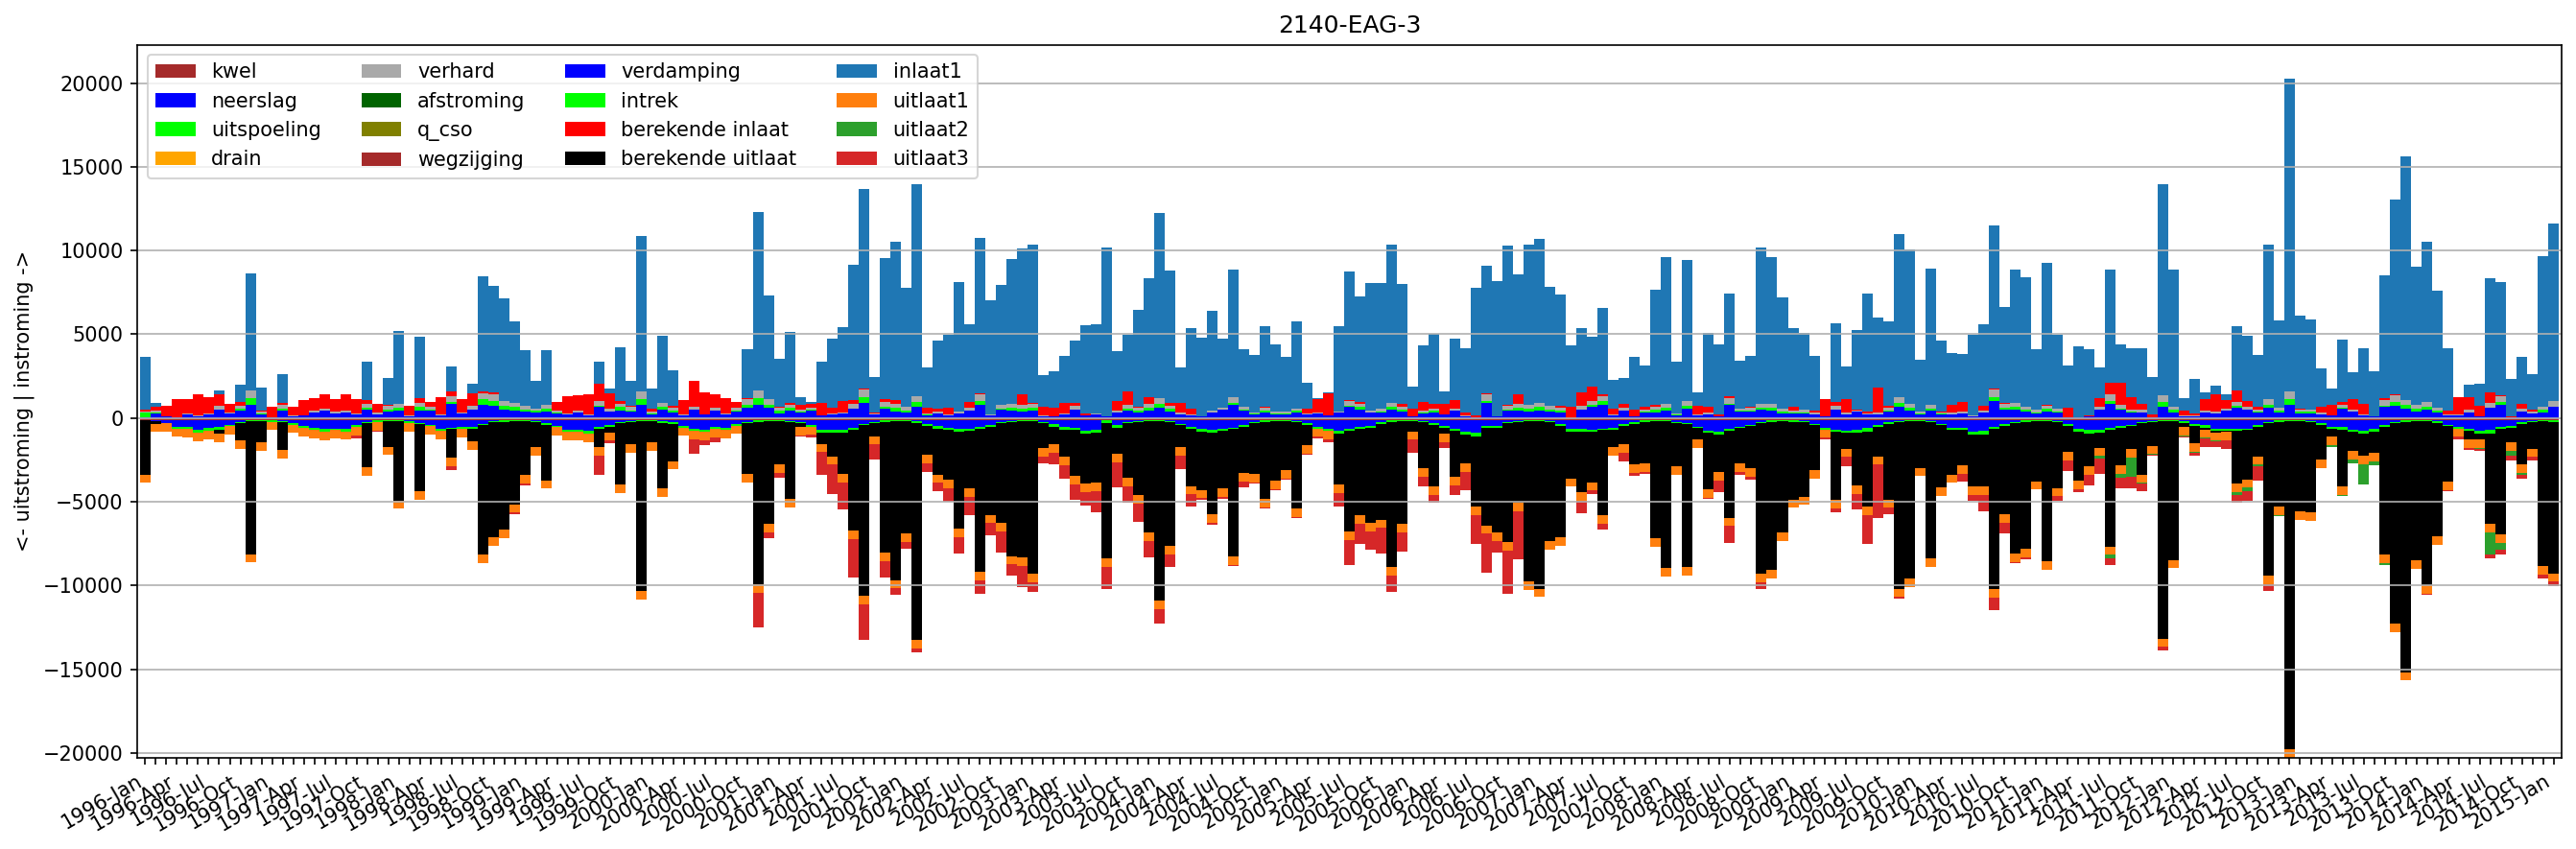

In [11]:
# Plot aggregated fluxes
e.plot.aggregated(tmin=tmin, tmax=tmax)
plt.show()

## [Running water balances from the database the easy way](#top)<a id="5"></a>

Prepare the input files by extracting the database csv files from `data/input_csv.zip`. The function in `waterbalansen_scripts.util` called `unzip_changed_files` unzips only files that have changed.

In [12]:
import sys

sys.path.insert(1, "../..")
from waterbalansen_scripts.util import unzip_changed_files

In [13]:
# Unzip changed files
unzip_changed_files(
    "../../data/input_csv.zip",
    "../../data/input_csv",
    check_time=True,
    check_size=True,
    debug=True,
)

Next the function `wb.run_eag_by_name()` can be used to run a specific EAG (or GAF) by name by pointing it to the directory with the extracted CSV files. This performs all the steps shown above for the user.

In [14]:
e = wb.run_eag_by_name(eag_name, csvdir="../../data/input_csv")

2024-11-04 17:02:56,434 | create_eag - INFO : Creating EAG object for '2140-EAG-3'
2024-11-04 17:02:56,440 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2024-11-04 17:02:56,442 | get_series - INFO : Adding ValueSeries timeseries 'Uitlaat1' for Bucket '-9999'.
2024-11-04 17:02:56,447 | get_series - INFO : Adding ValueSeries timeseries 'hTargetMin' for Bucket '60000000'.
2024-11-04 17:02:56,452 | get_series - INFO : Adding ValueSeries timeseries 'hTargetMax' for Bucket '60000000'.
2024-11-04 17:02:56,459 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 2' for Bucket '-9999'.
2024-11-04 17:02:56,460 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 1' for Bucket '-9999'.
2024-11-04 17:02:56,460 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 2' for Bucket '-9999'.
2024-11-04 17:02:56,461 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 1' for Bucket '-9999'.
2024-11-04 17:0